In [1]:
import os
os.chdir("../")
from algoritmo_genetico.pos import *
os.chdir("journal")
from plotly import express as px
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import patches
import matplotlib

def hausdorff_normalized(p,q):
    T=q.shape[1]
    from scipy.spatial.distance import directed_hausdorff
    return max(directed_hausdorff(p,q)[0],directed_hausdorff(q,p)[0])/np.sqrt(T)

In [2]:
grupos = {'A':'Immune','B':'Susceptible','C':'Highly Susceptible'}

In [3]:
# vertices con estructura de comunidad
vertices,edges=read("grafo_grado_12.graph")
grado_grupo =np.array([[len(vertice[2:]),grupos[vertice[1]]] for vertice in vertices])            
V=pd.DataFrame(grado_grupo,columns=['Grade','Group']).astype({'Grade': 'int64'})

In [4]:
# parametros modelo
modelo='g_m_v'
T=300
psi=0.98
nu=0.8
mu=0.14
lamda={'A':0,'B':0.005,'C':0.05}

In [5]:
# inicializacion uniforme aleatoria del miedo al crimen
s0=np.random.rand(len(vertices))

In [6]:
Adj=(np.zeros((len(vertices),len(vertices))) == 1)
n_vecinos=np.zeros(len(vertices))
for i in range(len(vertices)):
    n_vecinos[i]=len(vertices[i][2:])
    Adj[i][vertices[i][2:]]=True
T=23*52
n=len(vertices)
s=s0
St = np.zeros((T,n ))
St[0] = s
kappa=[2,2]+[round(i,2) for i in np.arange(0,2.1,0.1)[::-1]]
k=0
for t in range(1,T):
    if t % 52 == 0:        
        k=k+1
    
    s = psi * s       
    g=[kappa[k]*lamda[vertices[i][1]] for i in range(n) ]
    g=np.array(g)
    I=(np.random.poisson(g) > 0)*1
    s=I+(1-I)*s
    scopia=s.copy()
    
    media=(scopia*Adj).sum(axis=1)/n_vecinos
    w=(scopia > media)*mu + (scopia < media)*nu
    s=scopia-w*(scopia-media)
        
    St[t] = s

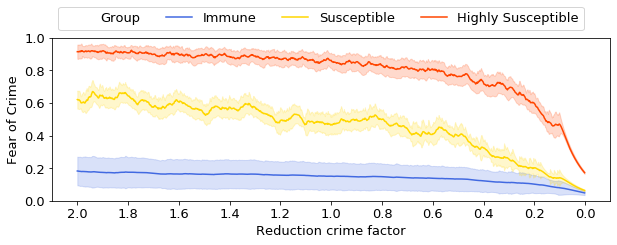

In [7]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
plt.figure(figsize=(10,3))

S=St.T[:,52*3:]
A=pd.DataFrame()
A['node']=np.array([[i]*(T-52*3) for i in range(S.shape[0])]).flatten()
A['Time']=list(np.arange(T-52*3))*S.shape[0]
A['Fear of Crime']=S.flatten()
A['Group']=V.Group[A.node].values

a=sns.lineplot(data=A,x='Time',y='Fear of Crime',hue='Group',ci='sd',
               hue_order=grupos.values(),palette=["royalblue","gold","orangered"],legend='full')
a.set_xticks(np.arange(0,52*21,104))
a.set_xticklabels([str(round(i,2)) for i in np.arange(0,2.1,0.2)[::-1]])
plt.legend(loc='upper left',ncol=4,bbox_to_anchor=(0,1.23))
plt.ylim(0,1)
plt.xlabel("Reduction crime factor")
plt.savefig("graficas/cambio_crimen_multi.pdf", bbox_inches = "tight")
plt.show()

<Figure size 720x216 with 0 Axes>

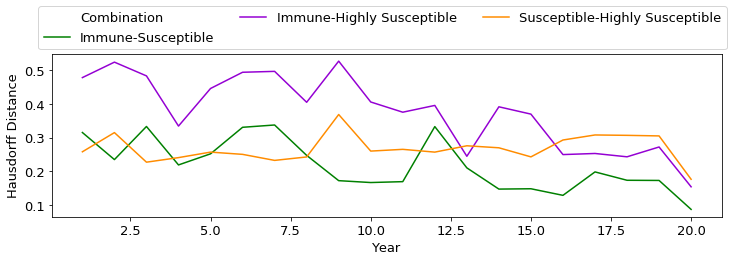

In [8]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
plt.figure(figsize=(10,3))


from itertools import combinations
comb=list(combinations(grupos,2))
comb
Distances=[]
for i in range(20):
    
    for c in comb:
        Distances.append([hausdorff_normalized(S[V.Group == grupos[c[0]],52*i:52*(i+1)],
                                              S[V.Group == grupos[c[1]],52*i:52*(i+1)]),
                         grupos[c[0]]+"-"+grupos[c[1]],i+1]
                        )
Distances=pd.DataFrame(Distances,columns=['Hausdorff Distance','Combination','Year'])
plt.figure(figsize=(12,3))
sns.lineplot(data=Distances,x='Year',y='Hausdorff Distance',hue='Combination',palette=['green','darkviolet','darkorange'])
plt.legend(loc='upper left',ncol=3,bbox_to_anchor=(-0.03,1.33))
plt.savefig("graficas/distance_crime_reduction_multi.pdf", bbox_inches = "tight")
plt.show()

In [9]:
T=23*52
n=1000
St = np.zeros((T,n ))
s=s0
St[0] = s
kappa=[2,2]+[round(i,2) for i in np.arange(0,2.1,0.1)[::-1]]
ka=0
for t in range(1,T):
    if t % 52 == 0:
        ka=ka+1
    s = psi * s       
    g=[kappa[ka]*lamda[vertices[i][1]] for i in range(n) ]
    g=np.array(g)
    I=(np.random.poisson(g) > 0)*1
    s=I+(1-I)*s
    scopia=s.copy()
    
    comu=np.random.permutation(n)[:int(n*0.1)]

    salto=[]

    for k in comu:

        if k in salto:
            continue

        if len(set(vertices[k][2:])-set(salto)) > 0:

            aux = np.random.choice(vertices[k][2:])

            if scopia[k] > scopia[aux]:
                s[k]=(1-mu)*scopia[k]+mu*scopia[aux]
                s[aux]=nu*scopia[k]+(1-nu)*scopia[aux]
            else:
                s[k]=(1-nu)*scopia[k]+nu*scopia[aux]
                s[aux]=mu*scopia[k]+(1-mu)*scopia[aux]

            salto.append(k)
            salto.append(aux)
        
    St[t] = s

<Figure size 720x216 with 0 Axes>

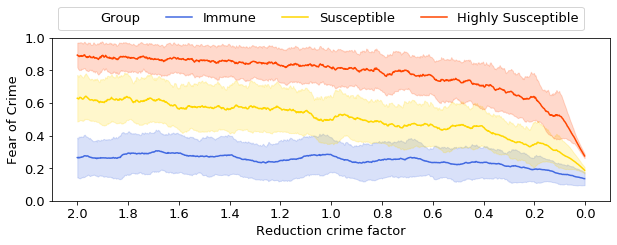

In [10]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
plt.figure(figsize=(10,3))
S=St.T[:,52*3:]
plt.figure(figsize=(10,3))
A=pd.DataFrame()
A['node']=np.array([[i]*(T-52*3) for i in range(S.shape[0])]).flatten()
A['Time']=list(np.arange(T-52*3))*S.shape[0]
A['Fear of Crime']=S.flatten()
A['Group']=V.Group[A.node].values

a=sns.lineplot(data=A,x='Time',y='Fear of Crime',hue='Group',ci='sd',
               hue_order=grupos.values(),palette=["royalblue","gold","orangered"],legend='full')
a.set_xticks(np.arange(0,52*21,104))
a.set_xticklabels([str(round(i,2)) for i in np.arange(0,2.1,0.2)[::-1]])
plt.legend(loc='upper left',ncol=4,bbox_to_anchor=(0,1.23))
plt.ylim(0,1)
plt.xlabel("Reduction crime factor")
#plt.savefig("graficas/cambio_crimen_one", bbox_inches = "tight")
plt.show()

In [11]:
T=23*52
n=1000
St = np.zeros((T,n ))
s=s0
St[0] = s
kappa=[2,2]+[round(i,2) for i in np.arange(0,2.1,0.1)[::-1]]
ka=0
for t in range(1,T):
    if t % 52 == 0:
        ka+=1
    s = psi * s       
    g=[kappa[ka]*lamda[vertices[i][1]] for i in range(n) ]
    g=np.array(g)
    I=(np.random.poisson(g) > 0)*1
    s=I+(1-I)*s
    scopia=s.copy()
    
 #numero de personas que se comunican
    n_comu=int(n*0.2)
    if n_comu % 2 == 1:
        n_comu+=1
    # indices personas que se comunican
    comu=np.random.permutation(n)[:n_comu]
    # primer persona de la pareja
    first=comu[int(n_comu/2):]
    # segunda persona de la pareja
    second=comu[:-int(n_comu/2)]
    # pesos persona uno a su opinion
    w1=(s[first]>s[second])*mu +(s[first]<s[second])*nu
    # pesos persona dos a su opinion
    w2=(s[second]>s[first])*mu +(s[second]<s[first])*nu
    # actualizacion todas las personas que se comunican
    s[first]=scopia[first]-w1*(scopia[first]-scopia[second])
    s[second]=scopia[second]-w2*(scopia[second]-scopia[first])
        
    St[t] = s

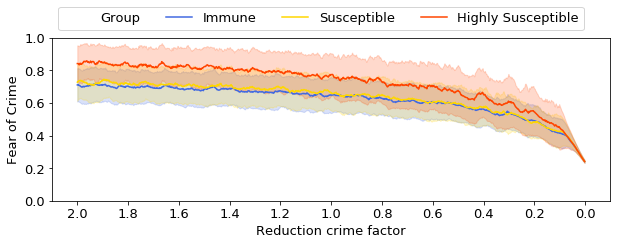

In [12]:
S=St.T[:,52*3:]
plt.figure(figsize=(10,3))
A=pd.DataFrame()
A['node']=np.array([[i]*(T-52*3) for i in range(S.shape[0])]).flatten()
A['Time']=list(np.arange(T-52*3))*S.shape[0]
A['Fear of Crime']=S.flatten()
A['Group']=V.Group[A.node].values

a=sns.lineplot(data=A,x='Time',y='Fear of Crime',hue='Group',ci='sd',
               hue_order=grupos.values(),palette=["royalblue","gold","orangered"],legend='full')
a.set_xticks(np.arange(0,52*21,104))
a.set_xticklabels([str(round(i,2)) for i in np.arange(0,2.1,0.2)[::-1]])
plt.legend(loc='upper left',ncol=4,bbox_to_anchor=(0,1.23))
plt.ylim(0,1)
plt.xlabel("Reduction crime factor")
plt.savefig("graficas/cambio_crimen_random.pdf", bbox_inches = "tight")
plt.show()

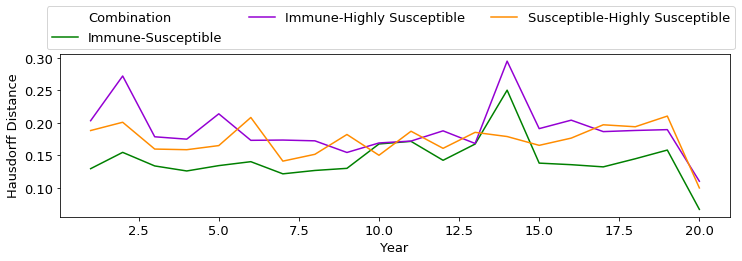

In [13]:
from itertools import combinations
comb=list(combinations(grupos,2))
comb
Distances=[]
for i in range(20):
    
    for c in comb:
        Distances.append([hausdorff_normalized(S[V.Group == grupos[c[0]],52*i:52*(i+1)],
                                              S[V.Group == grupos[c[1]],52*i:52*(i+1)]),
                         grupos[c[0]]+"-"+grupos[c[1]],i+1]
                        )
Distances=pd.DataFrame(Distances,columns=['Hausdorff Distance','Combination','Year'])
plt.figure(figsize=(12,3))
sns.lineplot(data=Distances,x='Year',y='Hausdorff Distance',hue='Combination',palette=['green','darkviolet','darkorange'])
plt.legend(loc='upper left',ncol=3,bbox_to_anchor=(-0.03,1.33))
plt.savefig("graficas/distance_crime_reduction_random.pdf", bbox_inches = "tight")
plt.show()